# 08 - Model Testing: Extending to other Cantons
### Author: Daniel Herrera-Russert
#### March 28, 2025

In [1]:
from owslib.wfs import WebFeatureService
import geopandas as gpd
from io import BytesIO
import os
import requests
import matplotlib.pyplot as plt
import json
import time
import re
from scipy.spatial import cKDTree
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
from adjustText import adjust_text

## 1. Cross-Cantonal Model Evaluation: Zurich to Luzern

As a continuation of the model evaluation, and especially in light of its surprisingly strong performance, we now turn to a critical question:

> Did the XGBoost model successfully capture underlying patterns in geothermal heat yield across the canton of Zurich due to regional homogeneity, or is it overfitting to localized data?

To address this, we test the model's ability to generalize by applying it to new data from the canton of **Luzern**. If the model performs well, this would suggest that the framework is not only robust but also extensible, and therefore an important step toward developing a nation-wide predictive tool for geothermal potential, without relying on the complexities of incorporating and modelling underground geological factors.

The Luzern dataset is a strong candidate for this evaluation, as it is structured similarly to Zurich's and likely shares comparable geographical and human useage characteristics. However, Luzern also presents new geological conditions, such as the presence of larger Voralpine mountain chains, which are absent in Zurich. These differences make it a valuable test case for assessing the model’s transferability to more geologically diverse locations in Switzerland.

The dataset can be accessed from the official [open data portal of the canton of Luzern](https://daten.geo.lu.ch/download/ewnutzxx_col_v3). Additionally, a [documentation page](https://daten.geo.lu.ch/produkt/ewnutzxx_col_v3) with a glossary for all fields can be found in the same portal.

---

### 1.1. Loading the Cantonal Boundary for Luzern

In [2]:
# URL of the GeoJSON file
geojson_url = "https://api3.geo.admin.ch/rest/services/api/MapServer/ch.swisstopo.swissboundaries3d-kanton-flaeche.fill/3?geometryFormat=geojson&sr=4326"

# Define output file path
output_geojson = "../data/raw/luzern/lu_boundary.geojson"

# Fetch the GeoJSON data
response = requests.get(geojson_url)

# Save to file
if response.status_code == 200:
    with open(output_geojson, "wb") as f:
        f.write(response.content)
    print(f"✅ Luzern boundary saved as '{output_geojson}'")
else:
    print("❌ Failed to download GeoJSON data.")

# Load into GeoPandas
boundary_gdf = gpd.read_file(output_geojson)

# Print CRS (coordinate system)
print(f"🗺️ Coordinate System: {boundary_gdf.crs}")

✅ Luzern boundary saved as '../data/raw/luzern/lu_boundary.geojson'
🗺️ Coordinate System: EPSG:4326


---

### 1.2. Assessment of the Erdwärmenutzung Dataset from Luzern

Because the data downloaded manually from the cantonal portal contains significantly more data points than the one retrieved via WFS service, likely due to hard limitations on data calls, we proceed with the first one for the analysis and validation of the Zürich model. The data was retrieved on the 29 of March 2025, and contains **13,938 rows**, and was downloaded as a shapefile.

In [3]:
lu_erdwaermenutzung_anlagen_gdf = gpd.read_file("../data/raw/luzern/EWNUTZXX_COL_V3_shp/daten/ERDWNUTZ_V1_PT.shp")
print(f"Number of items: {len(lu_erdwaermenutzung_anlagen_gdf)}")

# Load boundary
boundary_gdf = gpd.read_file("../data/raw/luzern/lu_boundary.geojson").to_crs("EPSG:2056")

lu_erdwaermenutzung_anlagen_gdf.head()

Number of items: 13839


,UUID,NUTZNR,SONDENART,STATUS,BEWDAT,REALISIERU,BETRIEBSZU,PARZELLEN,GBPER_NAME,BOHRUNGNAM,...,LAGENERKOE,BOPRWASSZU,BOPRGAS,BOPRKAVERN,BOPRANDERE,BEI_PZPLAN,BEI_HYDROL,BEI_ZUSVER,BEI_ANDERE,geometry
0,EDCC50F4FCDDE4ECE04028C2DFBD3740,006.109.1,99,1,1990/04/19,99,3,707,Rickenbach,None,...,None,0,0,0,0,0,0,0,0,POINT (2652551 1232850)
1,EDCC50F4F6A3E4ECE04028C2DFBD3740,005.130.1,99,1,2006/08/21,99,3,2240,Malters,None,...,None,0,0,0,0,0,0,0,0,POINT (2656496 1210630)
2,EDCC50F4E99FE4ECE04028C2DFBD3740,002.209.1,99,1,2005/11/07,99,99,1590,Adligenswil,None,...,None,0,0,0,0,0,0,0,0,POINT (2670130 1213365)
3,EDCC50F4F40BE4ECE04028C2DFBD3740,005.260.1,99,1,1996/08/16,99,3,1709,Meggen,None,...,None,0,0,0,0,0,0,0,0,POINT (2670340 1211020)
4,040836ecaf8c437fbbeb305688ffe31d,044.768.1,1,1,2020/02/13,1,1,2323,Escholzmatt,None,...,None,1,0,0,0,1,0,0,0,POINT (2637855 1196575)


A look into all the column names will allow us to identify the shared variables with the Zürich dataset:

In [4]:
for i in list(lu_erdwaermenutzung_anlagen_gdf.columns):
    print(i)

UUID
NUTZNR
SONDENART
STATUS
BEWDAT
REALISIERU
BETRIEBSZU
PARZELLEN
GBPER_NAME
BOHRUNGNAM
BOHRART
BOHRTIEFE
BOHRDURCHM
FELSTIEFE
SONDEN_ANZ
SONDSYSTEM
SONDLAENTO
SONDLAENEI
LEISTUNGAN
ZCK_HEIZUN
ZCK_KUEHLU
ZCK_WAWASS
ZCK_REGENE
ZCK_ANDERE
PUMPART
PUMPFABRIK
PUMPLEISTU
WAERMTRAEG
LAGENERKOE
BOPRWASSZU
BOPRGAS
BOPRKAVERN
BOPRANDERE
BEI_PZPLAN
BEI_HYDROL
BEI_ZUSVER
BEI_ANDERE
geometry


In [5]:
# Basic EDA for the dataset
def basic_eda(df):
    # Number of rows and columns
    num_rows, num_columns = df.shape
    print(f"Number of rows: {num_rows}")
    print(f"Number of columns: {num_columns}\n")
    
    # Data types of each column
    print("Data Types:")
    print(df.dtypes)
    print("\n")
    
    # Check for missing values
    print("Missing Values (Count and %):")
    missing = df.isnull().sum()
    missing_percent = (missing / num_rows) * 100
    missing_summary = pd.DataFrame({
        "Missing Count": missing,
        "Missing %": missing_percent.round(2)
    })
    print(missing_summary)
    print("\n")
    
    # Unique values for categorical variables
    print("Unique Values for Categorical Variables:")
    categorical_columns = df.select_dtypes(include='object').columns
    for col in categorical_columns:
        print(f"{col}: {df[col].nunique()} unique values")
    print("\n")
    
    # Summary statistics for numerical columns
    print("Summary Statistics for Numerical Variables:")
    print(df.describe())
    print("\n")

# Perform basic EDA on the dataset
basic_eda(lu_erdwaermenutzung_anlagen_gdf)

Number of rows: 13839
Number of columns: 38

Data Types:
UUID            object
NUTZNR          object
SONDENART        int32
STATUS           int32
BEWDAT          object
REALISIERU       int32
BETRIEBSZU       int32
PARZELLEN       object
GBPER_NAME      object
BOHRUNGNAM      object
BOHRART          int32
BOHRTIEFE      float64
BOHRDURCHM       int64
FELSTIEFE      float64
SONDEN_ANZ       int64
SONDSYSTEM       int32
SONDLAENTO       int64
SONDLAENEI       int64
LEISTUNGAN       int64
ZCK_HEIZUN       int32
ZCK_KUEHLU       int32
ZCK_WAWASS       int32
ZCK_REGENE       int32
ZCK_ANDERE       int32
PUMPART         object
PUMPFABRIK      object
PUMPLEISTU      object
WAERMTRAEG      object
LAGENERKOE      object
BOPRWASSZU       int32
BOPRGAS          int32
BOPRKAVERN       int32
BOPRANDERE       int32
BEI_PZPLAN       int32
BEI_HYDROL       int32
BEI_ZUSVER       int32
BEI_ANDERE       int32
geometry      geometry
dtype: object


Missing Values (Count and %):
            Missing Cou

A look at all the variables contained within the Luzern dataset shows a match with the raw version of the Zürich version used for training the XGBoost model, with the following equivalent fields:

| Column Name ZH | Column Name LU | Description |
|----------------------|-----------------|-------------|
|`WAERMEENTNAHME`|`PUMPLEISTUNG`|Power output of the heat pump system (kW).|
|`SONDENTIEFE`|`BOHRTIEFE`|Drilling depth in meters.|
|`GESAMTSONDENANZAHL`|`SONDEN_ANZ`|Number of probes per installation.|
|`geometry`|`geometry`| Coordinates encoded as GeoJSON points. |

Additionally, the engineered spatial variables are required to run the new data through the predictive model, two of which (`nearest_borehole_dist` and `count_100m`) can be produced via geographical queries with the coordinate data stored in the `geometry` column, and the third `bottom_elevation` requiring the addition of the top elevation of each recorded point. This will be tackled next, as a fundamental step in enriching the dataset for the model features.

Another notable observation is the significantly richer descriptive quality of the Luzern dataset. It contains complementary attributes that are absent in the Zürich dataset, offering greater detail and nuance regarding EWS installations. This enhanced granularity could help capture unique geological characteristics and system-specific differences, potentially leading to more accurate and insightful analyses.


| Column Name LU  | Description                                 |
|------------------|---------------------------------------------|
| `SONDLAENTO`     | Sum length of all probes (m).               |
| `SONDLAENEI`     | Individual probe length (m).                |
| `FELSTIEFE`      | Depth to bedrock (m).                       |
| `BOHRDURCHM`     | Diameter of the borehole (mm).              |
| `WAERMTRAEG`     | Type of heat transfer fluid.                |
| `SONDSYSTEM`     | Configuration of the probe system (e.g., U-pipe). |

Given the project's primary focus on datasets from the canton of Zürich, this aspect will not be explored further at this stage. However, it is flagged as a valuable opportunity for future research, especially for expanding the scope and enhancing the depth of analysis in subsequent iterations of the study.

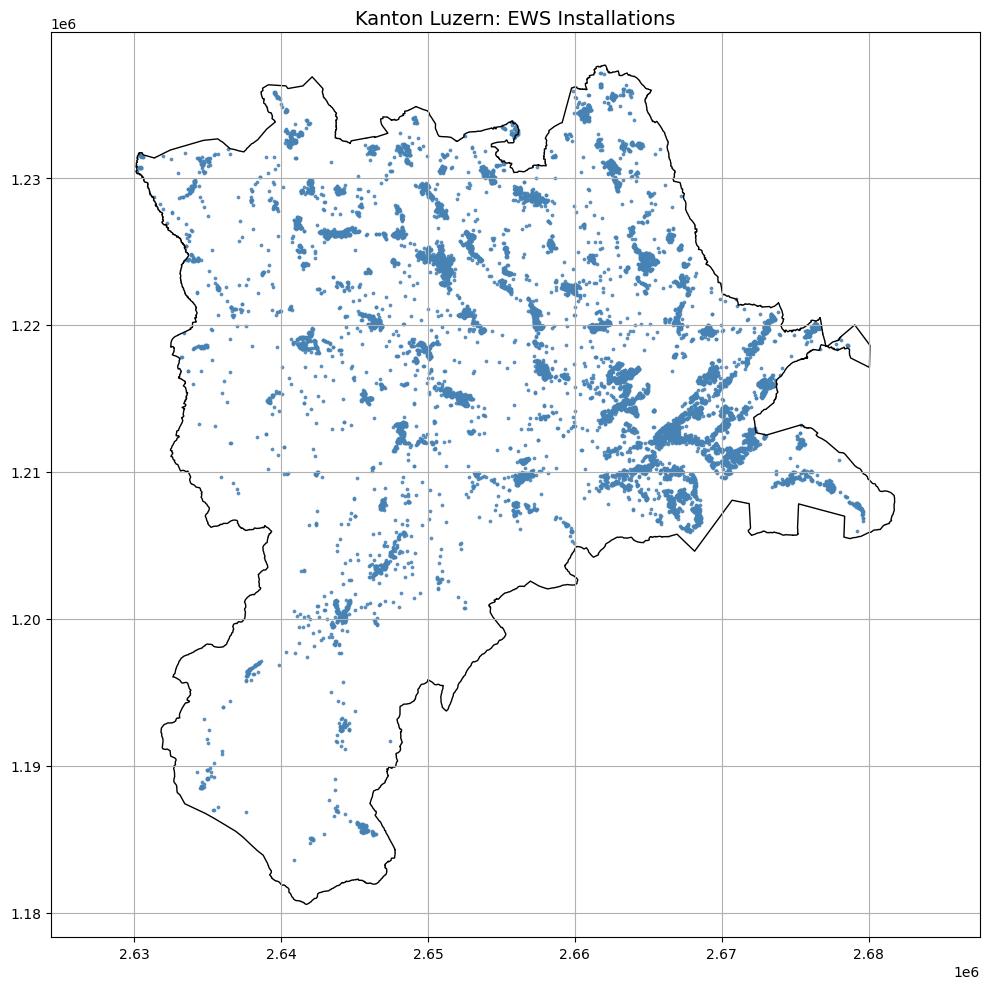

In [6]:
# Quick geographic plot
fig, ax = plt.subplots(figsize=(10, 10))
lu_erdwaermenutzung_anlagen_gdf.plot(ax=ax, markersize=3, color="steelblue", alpha=0.8)

# Overlay canton boundary
boundary_gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)

plt.title("Kanton Luzern: EWS Installations", fontsize=14)
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/08_01_lu_ews_map.svg", format="svg", bbox_inches="tight")
plt.savefig("plots/08_01_lu_ews_map.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

---

### 1.3. Implementing the Engineered Features

The remaining raw variable needed to complete all 3 engineered features is the top elevation of the ground heat installation for each point. The first step is to produce a subset of the Luzern dataset with the matching columns, and impute missing values in the power output variable.

This step focuses on preparing the Luzern geothermal probe dataset (`lu_erdwaermenutzung_anlagen_gdf`) for analysis by aligning it with the structure used for Zürich. We select only the relevant columns: heat pump output (`PUMPLEISTU`), probe depth (`BOHRTIEFE`), number of probes (`SONDEN_ANZ`), and geometry. These columns are renamed to match the Zürich naming convention: `Waermeentnahme`, `Sondentiefe`, and `Gesamtsondenzahl`.

Since the heat yield column (`PUMPLEISTU`) is stored as text and may contain commas as decimal separators, we first clean and convert it to numeric format. After this, we remove all rows that contain missing (`NaN`) values in any of the three key numeric fields (`Waermeentnahme`, `Sondentiefe`, `Gesamtsondenzahl`), as these rows would be invalid or incomplete for modeling and analysis.

This filtering step has perhaps the most drastic effect on the dataset, reducing the total number of usable data points by nearly half. The rationale behind this decision is to bring the Luzern dataset closer in structure and data quality to that of Zürich, which is more uniformly formatted and complete. By aligning the datasets in this way, we aim to create a more fair and comparable basis for applying the predictive model.

However, this decision does come with trade-offs. It is likely that some of the missing or zero values in Luzern are not errors, but rather represent meaningful cases, such as systems that are installed but not yet fully approved, systems still in planning, or incomplete documentation. For instance, entries with `Sondentiefe` or `Waermeentnahme` values of 0 might be placeholders, or could reflect certain types of installations not captured in the same way as in Zürich. This hints at important differences in data coding and interpretation practices between cantons.

Moreover, Luzern’s dataset is notably richer in terms of descriptive metadata. It contains many more fields than Zürich’s, including additional information about borehole conditions, probe types, usage purposes, documentation attachments, and system configurations. This additional complexity may partially explain the higher frequency of missing values, since more columns mean more potential for incomplete entries. At the same time, this richness points to a deeper potential for nuanced geothermal modeling, if harmonized and consistently populated.

In [7]:
# Subset and rename columns to match Zürich naming convention
lu_subset = lu_erdwaermenutzung_anlagen_gdf[[
    "PUMPLEISTU",    # Heat pump power output (text, kW)
    "BOHRTIEFE",     # Drilling depth (m)
    "SONDEN_ANZ",    # Number of probes
    "geometry"       # Spatial geometry
]].rename(columns={
    "PUMPLEISTU": "Waermeentnahme",
    "BOHRTIEFE": "Sondentiefe",
    "SONDEN_ANZ": "Gesamtsondenzahl"
})

# Clean and convert Waermeentnahme to numeric (e.g., replace commas with dots)
lu_subset["Waermeentnahme"] = (
    lu_subset["Waermeentnahme"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .apply(pd.to_numeric, errors="coerce")
)

# Count rows before dropping NaNs
initial_count = len(lu_subset)

# Drop rows with missing values in key columns
lu_subset = lu_subset.dropna(subset=["Waermeentnahme", "Sondentiefe", "Gesamtsondenzahl"])

# Count rows after cleaning
final_count = len(lu_subset)
removed_count = initial_count - final_count

print(f"✅ Removed {removed_count} rows with missing values in `Waermeentnahme`.")

# Optional: Reset index
lu_subset = lu_subset.reset_index(drop=True)

# Preview result
print(lu_subset.info())
print(lu_subset.describe())

✅ Removed 6427 rows with missing values in `Waermeentnahme`.
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7412 entries, 0 to 7411
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Waermeentnahme    7412 non-null   float64 
 1   Sondentiefe       7412 non-null   float64 
 2   Gesamtsondenzahl  7412 non-null   int64   
 3   geometry          7412 non-null   geometry
dtypes: float64(2), geometry(1), int64(1)
memory usage: 231.8 KB
None
       Waermeentnahme  Sondentiefe  Gesamtsondenzahl
count     7412.000000  7412.000000       7412.000000
mean        21.487696   154.979493          2.320831
std         30.146985    98.629244          3.057208
min          0.000000     0.000000          0.000000
25%          8.650000   110.000000          1.000000
50%         13.560000   182.000000          2.000000
75%         25.600000   220.000000          3.000000
max        800.000000  2201.000000         

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


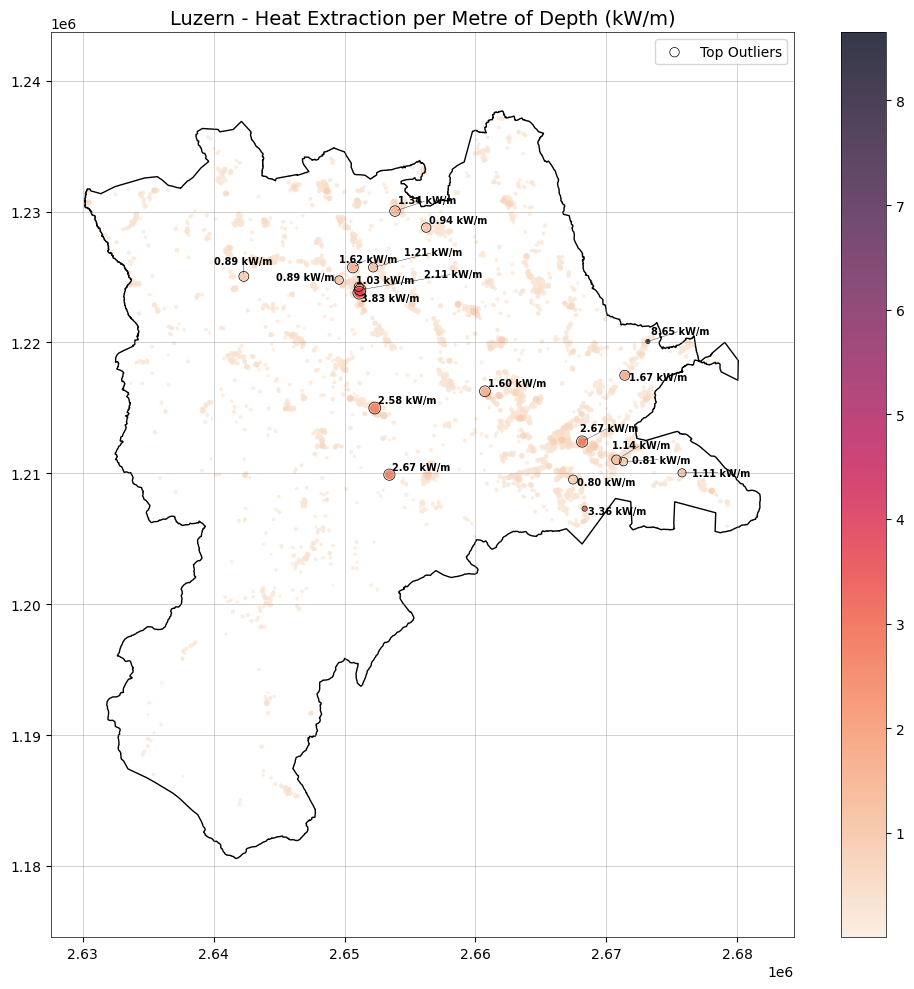

In [8]:
# Load Luzern boundary (already projected)
boundary_gdf = gpd.read_file("../data/raw/lu_boundary.geojson").to_crs("EPSG:2056")

# Filter valid rows (depth > 0 and Waermeentnahme > 0)
valid_df = lu_subset[
    (lu_subset["Sondentiefe"] > 0) &
    (lu_subset["Waermeentnahme"] > 0)
].copy()

# Compute heat extraction per meter
valid_df["heat_per_depth"] = valid_df["Waermeentnahme"] / valid_df["Sondentiefe"]

# Sort for better layering
valid_df.sort_values("heat_per_depth", ascending=True, inplace=True)

# Scale marker sizes (based on Waermeentnahme)
valid_df["scaled_size"] = np.sqrt(valid_df["Waermeentnahme"] + 1) * 2

# Identify top 20 by heat_per_depth
top_outliers = valid_df.sort_values("heat_per_depth", ascending=False).head(20)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all points, colored by heat_per_depth, sized by Waermeentnahme
scatter = ax.scatter(
    valid_df.geometry.x,
    valid_df.geometry.y,
    c=valid_df["heat_per_depth"],
    cmap="rocket_r",
    s=valid_df["scaled_size"],
    alpha=0.8,
    edgecolor="none"
)

# Plot Luzern canton boundary
boundary_gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)

# Highlight top outliers
ax.scatter(
    top_outliers.geometry.x,
    top_outliers.geometry.y,
    facecolors='none',
    edgecolors='black',
    s=top_outliers["scaled_size"] * 1.5,
    linewidths=0.5,
    label="Top Outliers"
)

# Annotate top outliers
texts = []
for idx, row in top_outliers.iterrows():
    texts.append(
        ax.text(
            row.geometry.x,
            row.geometry.y,
            f"{row['heat_per_depth']:.2f} kW/m",
            fontsize=7,
            color="black",
            weight='bold',
            ha='left',
            va='bottom'
        )
    )

# Adjust labels to prevent overlap
adjust_text(
    texts,
    ax=ax,
    expand_points=(2, 2),
    arrowprops=dict(arrowstyle="-", color="black", lw=0.25)
)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.outline.set_linewidth(0.5)  # Fix colorbar border thickness

# Final touches
plt.title("Luzern - Heat Extraction per Metre of Depth (kW/m)", fontsize=14)
plt.axis("equal")

# Solid gridlines
plt.grid(True, which="both", linestyle="-", linewidth=0.5, color="gray", alpha=0.5)

# Set axis spines thickness
for spine in ax.spines.values():
    spine.set_linewidth(0.5)

plt.legend()
plt.tight_layout()

# Save
plt.savefig("plots/08_02_lu_heat_extraction_per_depth_map.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

3 [ 0.49130375 -0.46400362]
4 [ 0.93395765 -0.4753892 ]


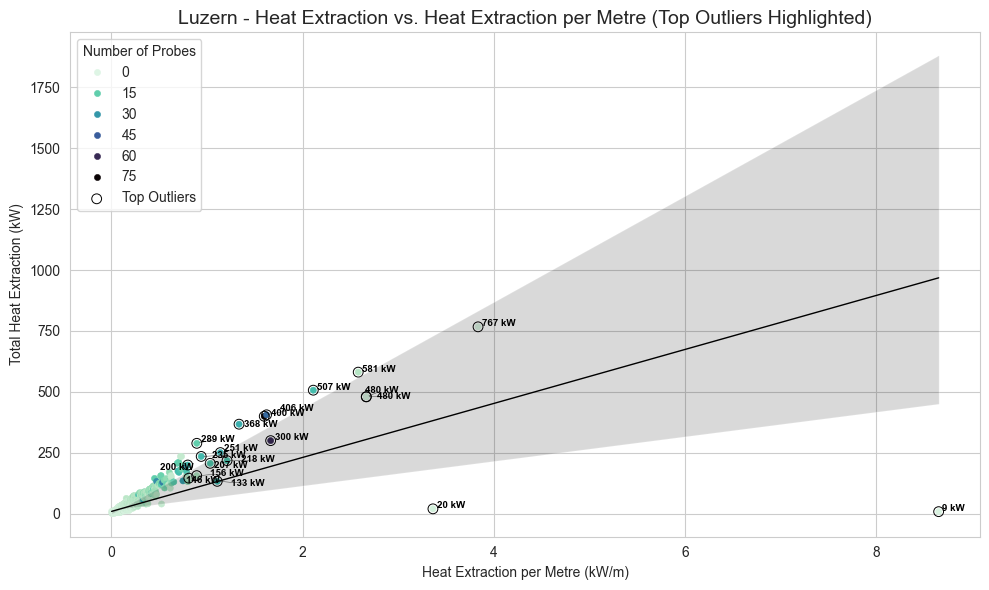

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Scatterplot all data
sns.scatterplot(
    data=valid_df,
    x="heat_per_depth",
    y="Waermeentnahme",
    hue="Gesamtsondenzahl",
    palette="mako_r",
    alpha=1,
    s=20,
    edgecolor=None,
)

# Plot the same top outliers
plt.scatter(
    top_outliers["heat_per_depth"],
    top_outliers["Waermeentnahme"],
    facecolors='none',
    edgecolors='black',
    s=50,  # slightly larger
    linewidths=0.7,
    label="Top Outliers"
)

# Annotate the top outliers with Waermeentnahme (kW)
texts = []
for idx, row in top_outliers.iterrows():
    texts.append(
        plt.text(
            row["heat_per_depth"],
            row["Waermeentnahme"],
            f"{row['Waermeentnahme']:.0f} kW",  # <<<<<< Annotating total heat extraction (kW)
            fontsize=7,
            color="black",
            weight='bold',
            ha='left',
            va='bottom'
        )
    )

# Adjust text labels to avoid overlaps
adjust_text(
    texts,
    expand_points=(2, 2),
    arrowprops=dict(arrowstyle="-", color="black", lw=0.25)
)

# Regression line (no hue)
sns.regplot(
    data=valid_df,
    x="heat_per_depth",
    y="Waermeentnahme",
    scatter=False,
    line_kws={"color": "black", "linewidth": 1},
)

# Titles and labels
plt.title("Luzern - Heat Extraction vs. Heat Extraction per Metre (Top Outliers Highlighted)", fontsize=14)
plt.xlabel("Heat Extraction per Metre (kW/m)")
plt.ylabel("Total Heat Extraction (kW)")

# Legend
plt.legend(title="Number of Probes", loc="best")

# Layout and save
plt.tight_layout()
plt.savefig("plots/08_03_lu_heat_extraction_vs_heat_per_depth_with_outliers.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

C:\Users\leina\AppData\Local\Temp\ipykernel_35368\1760978402.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_heat_per_bin_lu = lu_subset.groupby("depth_bin")["Waermeentnahme"].mean().reset_index()


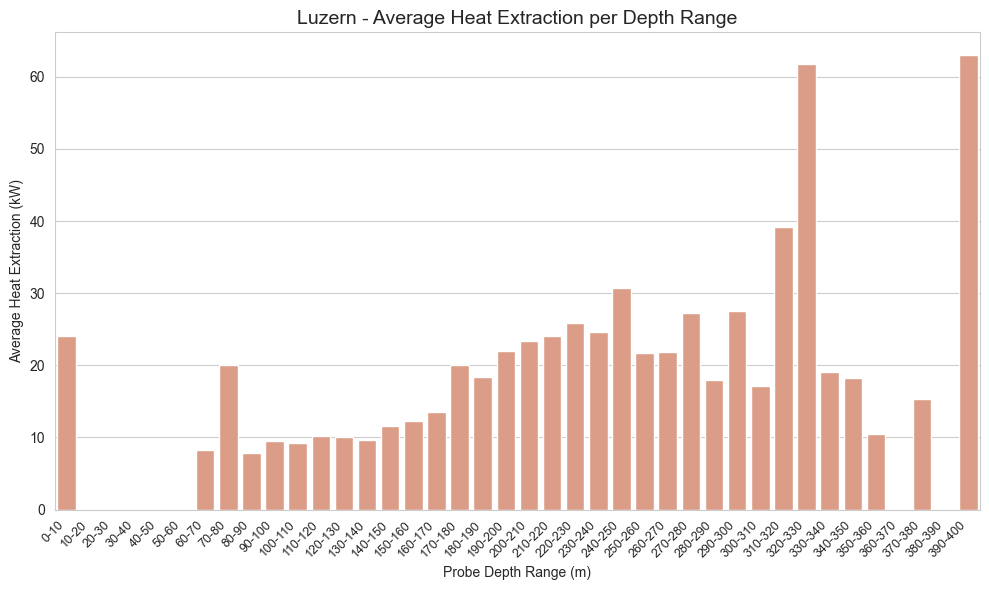

In [10]:
# Assuming lu_subset already has a "depth_bin" column
# If not, quickly create it again:
bin_edges = list(range(0, 401, 10))  # 150–160, 160–170, ..., 240–250
bin_labels = [f"{b}-{b+10}" for b in bin_edges[:-1]]

lu_subset["depth_bin"] = pd.cut(
    lu_subset["Sondentiefe"],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
)

# Group by depth bin and calculate mean heat yield
mean_heat_per_bin_lu = lu_subset.groupby("depth_bin")["Waermeentnahme"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.barplot(
    data=mean_heat_per_bin_lu,
    x="depth_bin",
    y="Waermeentnahme",
    color="darksalmon"
)

# Titles and labels
plt.title("Luzern - Average Heat Extraction per Depth Range", fontsize=14)
plt.xlabel("Probe Depth Range (m)")
plt.ylabel("Average Heat Extraction (kW)")

# Rotate x-ticks for better readability
plt.xticks(rotation=45, ha='right', fontsize=9)

# Layout and save
plt.tight_layout()
plt.savefig("plots/08_04_lu_average_heat_extraction_per_depth_bin.png", format="png", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\leina\AppData\Local\Temp\ipykernel_35368\1614811952.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_values_lu["depth_bin"], rotation=45, ha='right', fontsize=9)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite va

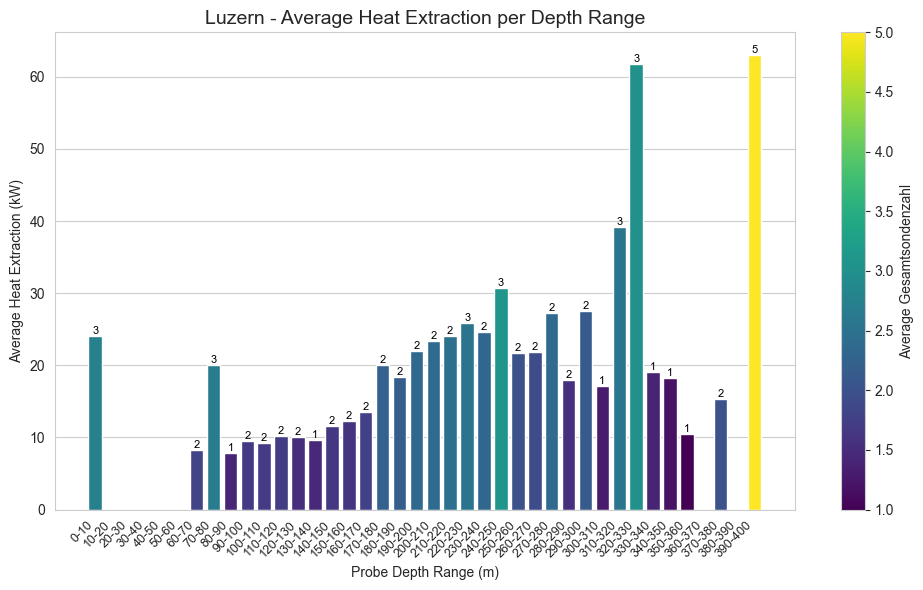

In [12]:
# Create depth bins if not already present
bin_edges = list(range(0, 401, 10))
bin_labels = [f"{b}-{b+10}" for b in bin_edges[:-1]]

lu_subset["depth_bin"] = pd.cut(
    lu_subset["Sondentiefe"],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
)

# Group by depth_bin and calculate mean values
mean_values_lu = lu_subset.groupby("depth_bin", observed=False)[["Waermeentnahme", "Gesamtsondenzahl"]].mean().reset_index()

# Normalize Gesamtsondenzahl for color mapping
norm = plt.Normalize(mean_values_lu["Gesamtsondenzahl"].min(), mean_values_lu["Gesamtsondenzahl"].max())
cmap = plt.cm.viridis
colors = cmap(norm(mean_values_lu["Gesamtsondenzahl"]))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style("whitegrid")
ax.grid(axis='x', visible=False)  # Remove vertical grid lines

bars = ax.bar(
    mean_values_lu["depth_bin"],
    mean_values_lu["Waermeentnahme"],
    color=colors
)

# Annotate bars with Gesamtsondenzahl
for bar, label in zip(bars, mean_values_lu["Gesamtsondenzahl"]):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{label:.0f}',
        ha='center',
        va='bottom',
        fontsize=8,
        color='black'
    )

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Average Gesamtsondenzahl")

# Titles and labels
ax.set_title("Luzern - Average Heat Extraction per Depth Range", fontsize=14)
ax.set_xlabel("Probe Depth Range (m)")
ax.set_ylabel("Average Heat Extraction (kW)")

# Rotate x-ticks
ax.set_xticklabels(mean_values_lu["depth_bin"], rotation=45, ha='right', fontsize=9)

# Layout and save
plt.tight_layout()
plt.savefig("plots/08_04_lu_average_heat_extraction_per_depth_bin_colored_labeled.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

In [70]:
lu_subset.describe()

,Waermeentnahme,Sondentiefe,Gesamtsondenzahl
count,7412.000000,7412.000000,7412.000000
mean,21.487696,154.979493,2.320831
std,30.146985,98.629244,3.057208
min,0.000000,0.000000,0.000000
25%,8.650000,110.000000,1.000000
50%,13.560000,182.000000,2.000000
75%,25.600000,220.000000,3.000000
max,800.000000,2201.000000,90.000000


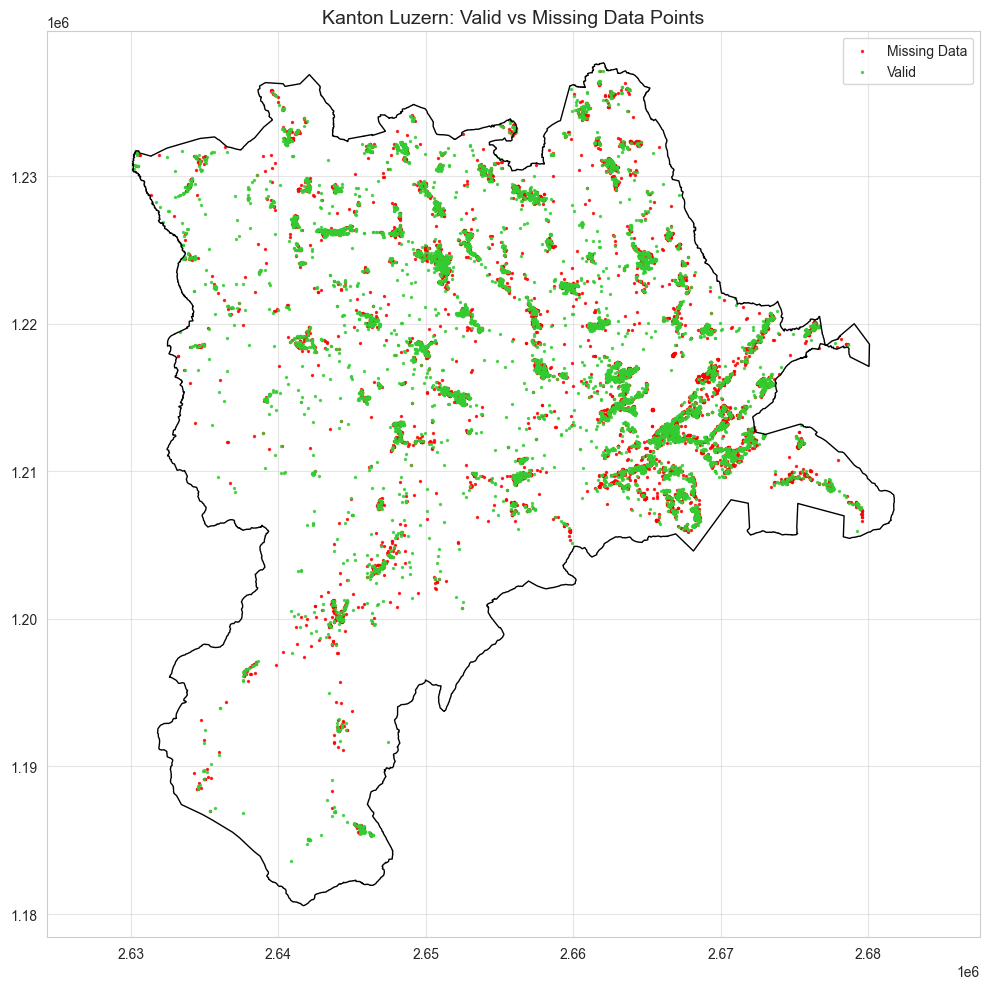

In [71]:
# Rename columns in original dataset to align with expected names
lu_original = lu_erdwaermenutzung_anlagen_gdf.rename(columns={
    "PUMPLEISTU": "Waermeentnahme",
    "BOHRTIEFE": "Sondentiefe",
    "SONDEN_ANZ": "Gesamtsondenzahl"
})

# Ensure 'Waermeentnahme' is numeric (same cleanup as before)
lu_original["Waermeentnahme"] = (
    lu_original["Waermeentnahme"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .apply(pd.to_numeric, errors="coerce")
)

# Identify missing and valid rows
missing_mask = lu_original[["Waermeentnahme", "Sondentiefe", "Gesamtsondenzahl"]].isna().any(axis=1)
valid_points = lu_original[~missing_mask]
invalid_points = lu_original[missing_mask]

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Invalid in red
invalid_points.plot(ax=ax, markersize=2, color="red", alpha=0.8, label="Missing Data")

# Valid in blue
valid_points.plot(ax=ax, markersize=2, color="limegreen", alpha=0.8, label="Valid")

# Optional: boundary
boundary_gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)

plt.title("Kanton Luzern: Valid vs Missing Data Points", fontsize=14)
plt.legend()
plt.axis("equal")
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.savefig("plots/08_02_lu_invalid_map.svg", format="svg", bbox_inches="tight")
plt.savefig("plots/08_02_lu_invalid_map.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

The following code leverages the **Swisstopo API** to assign an elevation value in metres above sea level to each geographical point from the Luzern dataset:

In [72]:
# Function to get elevation from swisstopo API
def get_elevation(easting, northing):
    url = "https://api3.geo.admin.ch/rest/services/height"
    params = {
        "easting": easting,
        "northing": northing,
        "sr": 2056
    }
    headers = {"User-Agent": "Mozilla/5.0"}

    try:
        r = requests.get(url, params=params, headers=headers)
        if r.status_code == 200:
            return float(r.json().get("height", None))
    except Exception as e:
        print(f"⚠️ Error at point ({easting}, {northing}): {e}")
    return None

# Add elevation to the dataframe
elevations = []

print("📡 Fetching elevation for all points...")
for idx, row in lu_subset.iterrows():
    x, y = row.geometry.x, row.geometry.y
    elevation = get_elevation(x, y)
    elevations.append(elevation)

    if idx % 1000 == 0 and idx != 0:
        print(f"✅ Processed {idx} points")

    time.sleep(0.05)  # avoid hitting rate limits

# Assign new column
lu_subset["top_elevation"] = elevations

# Create output directory if it doesn't exist
output_path = "../data/transformed"
os.makedirs(output_path, exist_ok=True)

# Save GeoDataFrame
output_file = os.path.join(output_path, "lu_geothermal_probes.geojson")
lu_subset.to_file(output_file, driver="GeoJSON")

print(f"✅ Done! Saved to: {output_file}")

📡 Fetching elevation for all points...
✅ Processed 1000 points
✅ Processed 2000 points
✅ Processed 3000 points
✅ Processed 4000 points
✅ Processed 5000 points
✅ Processed 6000 points
✅ Processed 7000 points
✅ Done! Saved to: ../data/transformed\lu_geothermal_probes.geojson


---

#### 1.3.1. Count within 100 m

In [73]:
# Load the file back from scratch
lu_subset_gdf = gpd.read_file("../data/transformed/lu_geothermal_probes.geojson")

In [74]:
lu_subset.head()

,Waermeentnahme,Sondentiefe,Gesamtsondenzahl,geometry,top_elevation
0,12.00,210.0,1,POINT (2637855 1196575),854.6
1,11.70,210.0,1,POINT (2643491 1226265),536.7
2,58.79,300.0,2,POINT (2650771 1223740),505.8
3,30.70,200.0,3,POINT (2647750 1224145),540.3
4,25.60,232.0,2,POINT (2642322 1224933),515.1


In [75]:
# Extract coordinate tuples directly from geometry
coords = np.array([(point.x, point.y) for point in lu_subset.geometry])
# Create KDTree for efficient spatial queries
tree = cKDTree(coords)

In [76]:
r = 100
print(f"Computing radius {r}m ...")
lu_subset[f'count_{r}m'] = [len(tree.query_ball_point(coord, r)) - 1 for coord in coords]
print(f"✔")

# Save the updated dataset
output_path = "../data/transformed/lu_geothermal_probes.geojson"
lu_subset.to_file(output_path, driver="GeoJSON")

# Display first few rows
lu_subset.head()[["count_100m"]]

Computing radius 100m ...
✔


,count_100m
0,1
1,11
2,13
3,1
4,0


---

#### 1.3.2. Nearest Neighbour Distance

In [77]:
# Extract coordinate tuples from geometry
coords = np.array([(point.x, point.y) for point in lu_subset.geometry])

# Create KDTree
tree = cKDTree(coords)

# Query the nearest neighbor for each point (excluding itself)
distances, indices = tree.query(coords, k=2)  # k=2 because the first result is the point itself

# The second column contains the distance to the nearest neighbor
lu_subset["nearest_borehole_dist"] = distances[:, 1]

# Display first few rows
lu_subset.head()[["nearest_borehole_dist"]]

,nearest_borehole_dist
0,40.607881
1,7.000000
2,34.409301
3,55.036352
4,114.140265


In [78]:
# Save the updated dataset
output_path = "../data/transformed/lu_geothermal_probes.geojson"
lu_subset.to_file(output_path, driver="GeoJSON")

---

#### 1.3.3. Bottom Elevation

In [79]:
# Compute bottom elevation
lu_subset["bottom_elevation"] = lu_subset["top_elevation"] - lu_subset["Sondentiefe"]

# Display updated dataframe
lu_subset[["top_elevation", "Sondentiefe", "bottom_elevation"]].head()

,top_elevation,Sondentiefe,bottom_elevation
0,854.6,210.0,644.6
1,536.7,210.0,326.7
2,505.8,300.0,205.8
3,540.3,200.0,340.3
4,515.1,232.0,283.1


In [80]:
# Save the updated dataset
output_path = "../data/transformed/lu_geothermal_probes.geojson"
lu_subset.to_file(output_path, driver="GeoJSON")

print(f"✅ Done! Saved to: {output_file}")

✅ Done! Saved to: ../data/transformed\lu_geothermal_probes.geojson


---

## 2. Exploration of the Luzern Data

In [81]:
# Load the data from scratch
lu_geothermal_probes_gdf = gpd.read_file("../data/transformed/lu_geothermal_probes.geojson")

In [82]:
lu_geothermal_probes_gdf.isna().sum()

Waermeentnahme           0
Sondentiefe              0
Gesamtsondenzahl         0
top_elevation            0
count_100m               0
nearest_borehole_dist    0
bottom_elevation         0
geometry                 0
dtype: int64

In [83]:
lu_geothermal_probes_gdf.describe()

,Waermeentnahme,Sondentiefe,Gesamtsondenzahl,top_elevation,count_100m,nearest_borehole_dist,bottom_elevation
count,7412.000000,7412.000000,7412.000000,7412.000000,7412.000000,7412.000000,7412.000000
mean,21.487696,154.979493,2.320831,560.001619,4.529412,83.859829,405.022126
std,30.146985,98.629244,3.057208,115.419304,5.130763,162.150679,150.246299
min,0.000000,0.000000,0.000000,408.700000,0.000000,0.000000,-1689.200000
25%,8.650000,110.000000,1.000000,492.200000,1.000000,22.321411,300.600000
50%,13.560000,182.000000,2.000000,526.500000,3.000000,38.118237,375.900000
75%,25.600000,220.000000,3.000000,591.100000,6.000000,68.731361,491.525000
max,800.000000,2201.000000,90.000000,1475.800000,43.000000,2899.379934,1461.200000


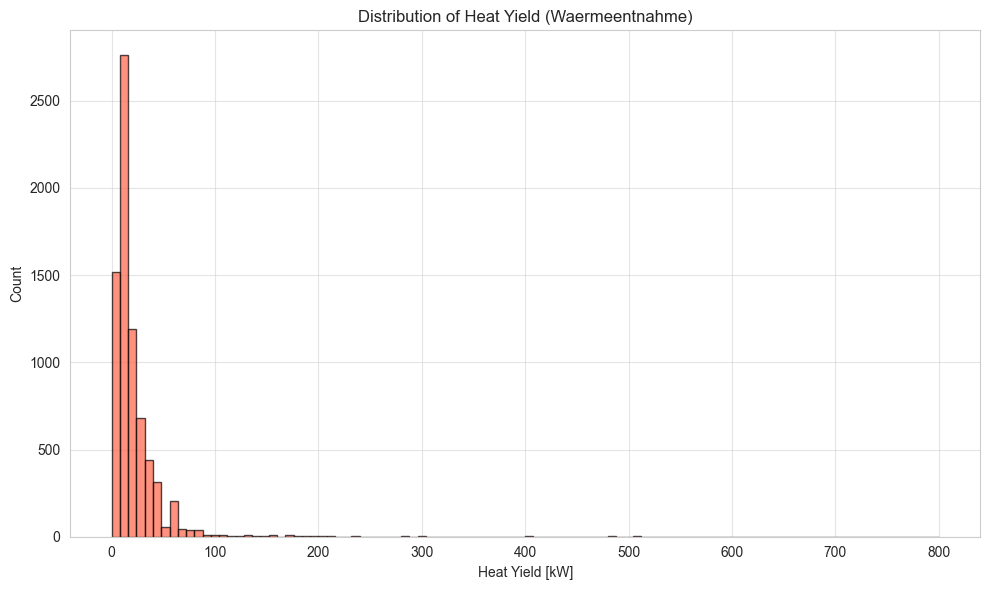

In [84]:
# Set figure size and style
plt.figure(figsize=(10, 6))
plt.hist(lu_geothermal_probes_gdf["Waermeentnahme"], bins=100, color="tomato", alpha=0.7, edgecolor="black")

# Add labels and title
plt.title("Distribution of Heat Yield (Waermeentnahme)")
plt.xlabel("Heat Yield [kW]")
plt.ylabel("Count")

# Optional grid
plt.grid(True, alpha=0.5)
# Show plot
plt.tight_layout()
plt.savefig("plots/08_03_lu_heat_hist.svg", format="svg", bbox_inches="tight")
plt.savefig("plots/08_03_lu_heat_hist.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

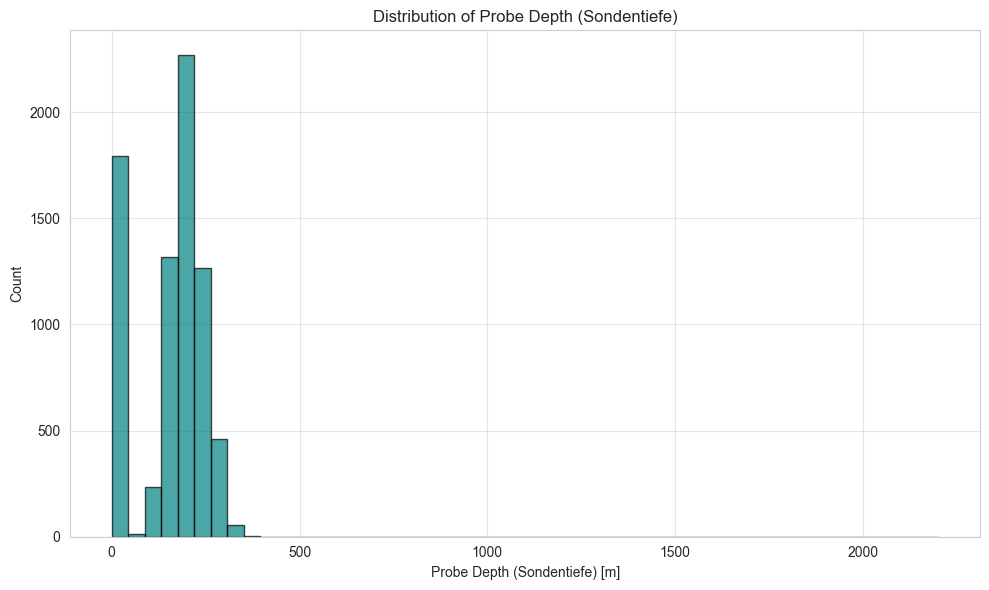

In [85]:
# Set figure size and style
plt.figure(figsize=(10, 6))
plt.hist(lu_geothermal_probes_gdf["Sondentiefe"], bins=50, color="teal", alpha=0.7, edgecolor="black")

# Add labels and title
plt.title("Distribution of Probe Depth (Sondentiefe)")
plt.xlabel("Probe Depth (Sondentiefe) [m]")
plt.ylabel("Count")

# Optional grid
plt.grid(True, alpha=0.5)
# Show plot
plt.tight_layout()
plt.savefig("plots/08_04_lu_depth_hist.svg", format="svg", bbox_inches="tight")
plt.savefig("plots/08_04_lu_depth_hist.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

The first thing that stands out is the comparetively large portion of probes with little or no depth associated with them, which contrasts with a distribution very similar to the one in the canton Zürich. A quick adjustment by removing the depth 0 items from the data will return an almost identical histogram plot, with most values clustering around the 250 metre mark, as well as a sporadic outlier of around 2,300 metres in depth.

In [86]:
# Filter out installations with zero drilling depth
lu_filtered_depth = lu_geothermal_probes_gdf[lu_geothermal_probes_gdf["Sondentiefe"] > 0].copy()

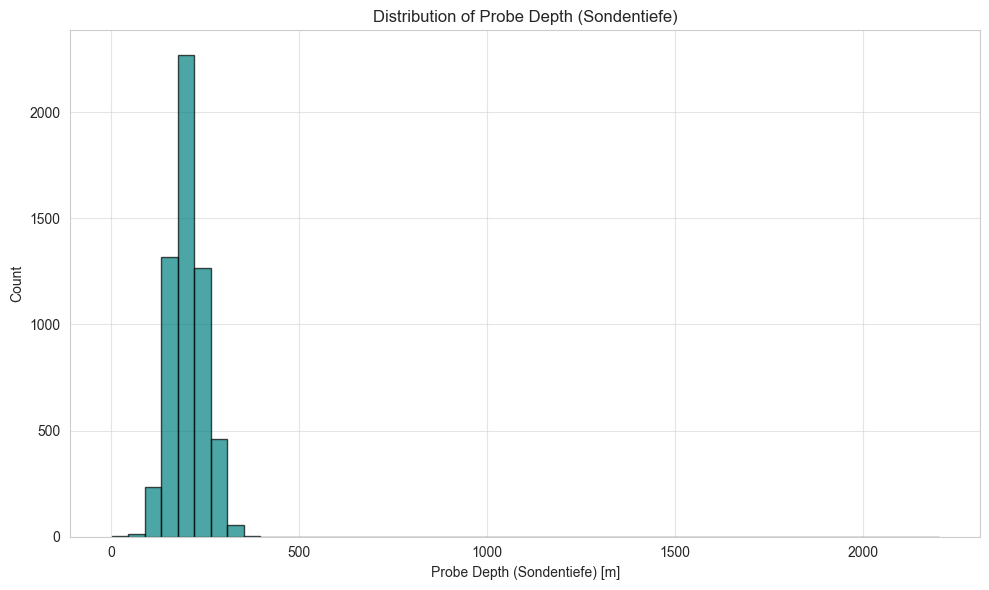

In [87]:
# Set figure size and style
plt.figure(figsize=(10, 6))
plt.hist(lu_filtered_depth["Sondentiefe"], bins=50, color="teal", alpha=0.7, edgecolor="black")

# Add labels and title
plt.title("Distribution of Probe Depth (Sondentiefe)")
plt.xlabel("Probe Depth (Sondentiefe) [m]")
plt.ylabel("Count")

# Optional grid
plt.grid(True, alpha=0.5)
# Show plot
plt.tight_layout()
plt.savefig("plots/08_05_lu_depth_hist.svg", format="svg", bbox_inches="tight")
plt.savefig("plots/08_05_lu_depth_hist.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

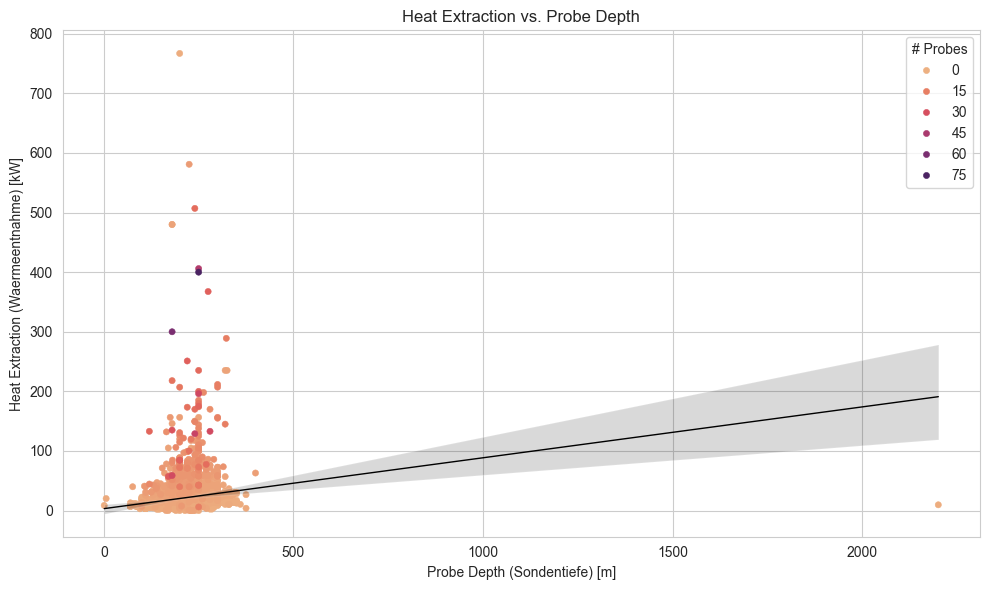

In [88]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Sort so high "Gesamtsondenzahl" values plot last
sorted_df = lu_filtered_depth.sort_values(by="Gesamtsondenzahl", ascending=True)

# Use scatterplot for color encoding
sns.scatterplot(
    data=sorted_df,
    x="Sondentiefe",
    y="Waermeentnahme",
    hue="Gesamtsondenzahl",
    palette="flare",  # or "coolwarm", "magma", etc.
    alpha=1,
    s=20,
    edgecolor=None,
)

# Add regression line (ignoring hue, purely for trend)
sns.regplot(
    data=lu_filtered_depth,
    x="Sondentiefe",
    y="Waermeentnahme",
    scatter=False,
    line_kws={"color": "black", "linewidth": 1},
)

plt.title("Heat Extraction vs. Probe Depth")
plt.xlabel("Probe Depth (Sondentiefe) [m]")
plt.ylabel("Heat Extraction (Waermeentnahme) [kW]")
plt.legend(title="# Probes")
plt.tight_layout()
plt.savefig("plots/08_06_lu_heat_extraction_vs_depth.svg", format="svg", bbox_inches="tight")
plt.savefig("plots/08_06_lu_heat_extraction_vs_depth.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

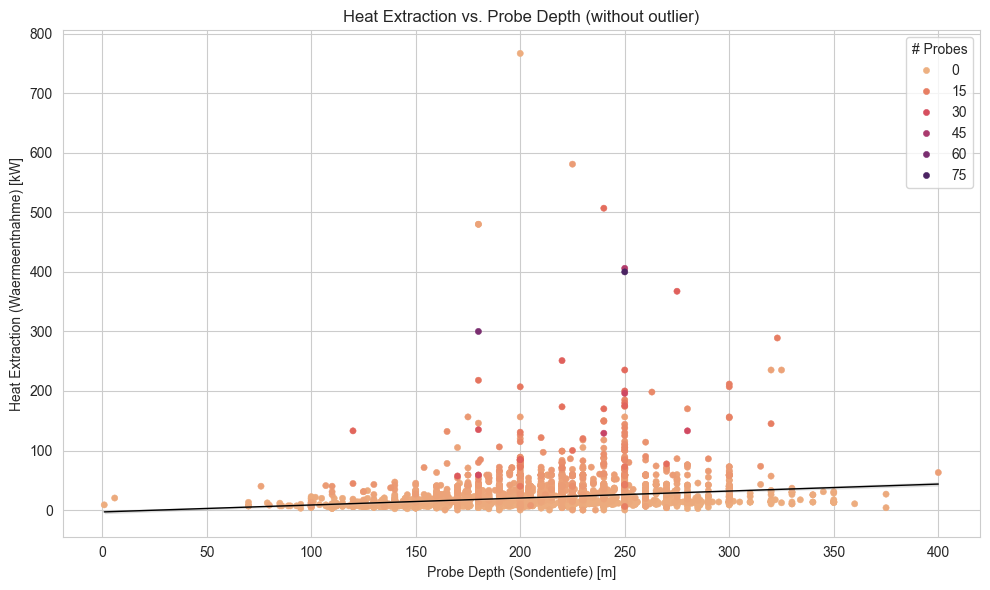

In [89]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

filtered_df = sorted_df[sorted_df["Sondentiefe"] < 2000]

# Use scatterplot for color encoding
sns.scatterplot(
    data=filtered_df,
    x="Sondentiefe",
    y="Waermeentnahme",
    hue="Gesamtsondenzahl",
    palette="flare",  # or "coolwarm", "magma", etc.
    alpha=1,
    s=20,
    edgecolor=None,
)

# Add regression line (ignoring hue, purely for trend)
sns.regplot(
    data=filtered_df,
    x="Sondentiefe",
    y="Waermeentnahme",
    scatter=False,
    line_kws={"color": "black", "linewidth": 1},
)

plt.title("Heat Extraction vs. Probe Depth (without outlier)")
plt.xlabel("Probe Depth (Sondentiefe) [m]")
plt.ylabel("Heat Extraction (Waermeentnahme) [kW]")
plt.legend(title="# Probes")
plt.tight_layout()
plt.savefig("plots/08_07_lu_heat_extraction_vs_depth.svg", format="svg", bbox_inches="tight")
plt.savefig("plots/08_07_lu_heat_extraction_vs_depth.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

---

## 3. Running the Baseline Linear Model with Luzern Data

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [6]:
# Load the data from scratch
lu_geothermal_probes_gdf = gpd.read_file("../data/transformed/lu_geothermal_probes.geojson")

# Load the model
model_path = "../models/lr_zh_energy_yield.pkl"
linear_model = joblib.load(model_path)

In [7]:
features = ["Gesamtsondenzahl", "count_100m", "nearest_borehole_dist", "Sondentiefe", "bottom_elevation"]
target = "Waermeentnahme"

X = lu_geothermal_probes_gdf[features]
y = lu_geothermal_probes_gdf[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"R-squared: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

R-squared: 0.533
RMSE: 21.324
MAE: 7.043


---

## 4. Running the Tuned Model with Luzern Data

In [13]:
# Load the data from scratch
lu_geothermal_probes_gdf = gpd.read_file("../data/transformed/lu_geothermal_probes.geojson")

# Load the models
xgb_model = joblib.load("../models/xgb_zh_energy_yield.pkl")
linear_model = joblib.load("../models/lr_zh_energy_yield.pkl")

In [14]:
# Define features and target
feature_columns = ["Gesamtsondenzahl", "count_100m", "nearest_borehole_dist", "Sondentiefe", "bottom_elevation"]

# Make predictions
X = lu_geothermal_probes_gdf[feature_columns]
y_pred = xgb_model.predict(X)
lu_geothermal_probes_gdf.loc[lu_geothermal_probes_gdf.index, 'Waermeentnahme_predicted'] = y_pred

# Predict using the same feature columns
X_lu = lu_geothermal_probes_gdf[feature_columns]
y_pred_linear = linear_model.predict(X_lu)
lu_geothermal_probes_gdf["Waermeentnahme_predicted_linear"] = y_pred_linear

In [15]:
y_true = lu_geothermal_probes_gdf["Waermeentnahme"]
y_pred = lu_geothermal_probes_gdf["Waermeentnahme_predicted"]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"R² Score: {r2:.3f}")
print(f"MAE: {mae:.2f} kW")
print(f"RMSE: {rmse:.2f} kW")

R² Score: 0.279
MAE: 8.77 kW
RMSE: 25.59 kW


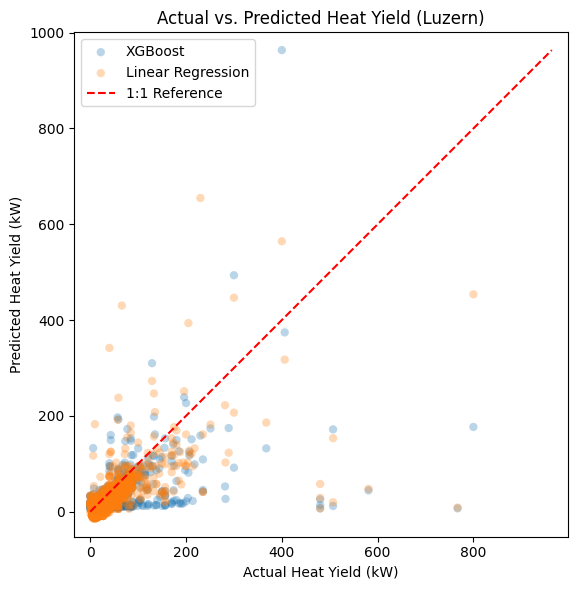

In [16]:
plt.figure(figsize=(6, 6))

# XGBoost predictions
plt.scatter(
    lu_geothermal_probes_gdf["Waermeentnahme"],
    lu_geothermal_probes_gdf["Waermeentnahme_predicted"],
    alpha=0.3,
    edgecolor="none",
    label="XGBoost"
)

# Linear model predictions
plt.scatter(
    lu_geothermal_probes_gdf["Waermeentnahme"],
    lu_geothermal_probes_gdf["Waermeentnahme_predicted_linear"],
    alpha=0.3,
    edgecolor="none",
    label="Linear Regression"
)

# Reference line
max_val = max(
    lu_geothermal_probes_gdf["Waermeentnahme"].max(),
    lu_geothermal_probes_gdf["Waermeentnahme_predicted"].max(),
    lu_geothermal_probes_gdf["Waermeentnahme_predicted_linear"].max()
)
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label="1:1 Reference")

# Labels and styling
plt.xlabel("Actual Heat Yield (kW)")
plt.ylabel("Predicted Heat Yield (kW)")
plt.title("Actual vs. Predicted Heat Yield (Luzern)")
plt.legend()
plt.axis("equal")
plt.tight_layout()
plt.savefig("plots/08_08_lu_actual_pred_comparison.png", format="png", dpi=300, bbox_inches="tight")
plt.show()


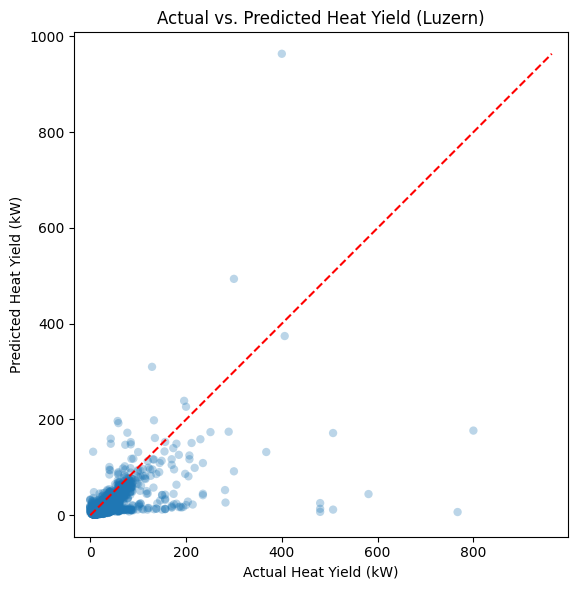

In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(
    lu_geothermal_probes_gdf["Waermeentnahme"],
    lu_geothermal_probes_gdf["Waermeentnahme_predicted"],
    alpha=0.3, edgecolor="none"
)
plt.plot([0, max(y_pred)], [0, max(y_pred)], color='red', linestyle='--')
plt.xlabel("Actual Heat Yield (kW)")
plt.ylabel("Predicted Heat Yield (kW)")
plt.title("Actual vs. Predicted Heat Yield (Luzern)")
plt.axis("equal")
plt.tight_layout()
plt.savefig("plots/08_08_lu_actual_pred.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

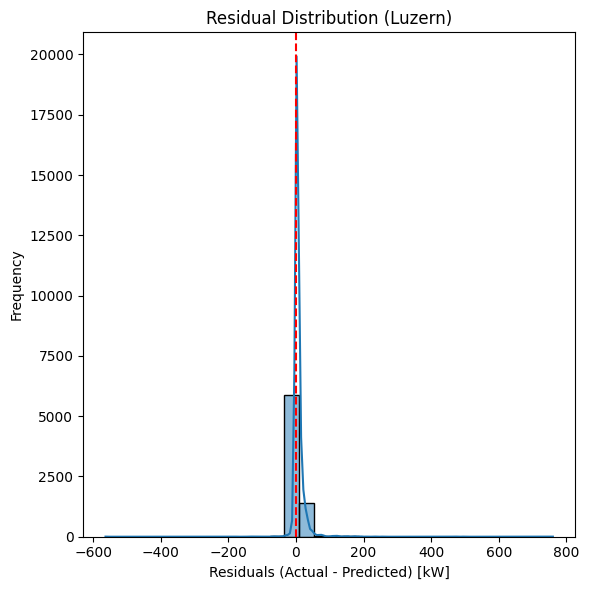

In [9]:
# Calculate residuals (Actual - Predicted for consistency)
lu_geothermal_probes_gdf["residual"] = (
    lu_geothermal_probes_gdf["Waermeentnahme"] - lu_geothermal_probes_gdf["Waermeentnahme_predicted"]
)

# Plot residual distribution
plt.figure(figsize=(6, 6))
sns.histplot(lu_geothermal_probes_gdf["residual"], kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')  # Zero error line

plt.xlabel("Residuals (Actual - Predicted) [kW]")
plt.ylabel("Frequency")
plt.title("Residual Distribution (Luzern)")
plt.tight_layout()

plt.savefig("plots/08_09_lu_residual_dist.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

Exluding installations where the recorded heat yield was 0, there were also many with `Sondentiefe` 0.

After consistently cleaning the Luzern dataset by removing entries with missing or invalid values in key fields (`Waermeentnahme`, `Sondentiefe`, `Gesamtsondenzahl`), the XGBoost model trained on data from the canton of Zürich achieved the following results when applied to Luzern:

- **R² Score:** 0.279  
- **MAE:** 8.77 kW  
- **RMSE:** 25.59 kW  

These metrics indicate that the model has **limited predictive power** when applied outside its original context. An R² value of 0.279 suggests that only around 28% of the variation in heat yield can be explained by the model’s features, while the error metrics reveal that significant discrepancies remain between predicted and actual values. Although not entirely random, the predictions are far from accurate and indicate a clear **lack of generalization** when transferring the model from Zürich to Luzern.

Several factors contribute to this outcome. Most notably, **inconsistencies in variable definitions and data structures across cantons** introduce ambiguity and complexity. For example, the key variable for heat yield in the Luzern dataset (`PUMPLEISTUNG`) is stored as a text field and may contain multiple comma-separated values — potentially corresponding to multiple heat pumps or probe clusters. In our approach, we interpreted this as total system output and **aggregated the values into a single float value**, assuming they referred to one combined installation. While this was a reasonable assumption based on context, it inevitably introduces a layer of **subjective interpretation** that could alter results significantly if the data semantics were different.

This highlights a broader issue: **the ease with which results and model performance can change depending on how variables are labeled, collected, and interpreted.** Without clear, consistent metadata or documentation across cantons, even simple fields like heat yield can become difficult to align. Moreover, many official records reflect **planned or permitted system parameters**, not measured energy extraction under operating conditions — which weakens the model’s ability to reflect real-world performance.

Nonetheless, the experiment reveals promising potential. By combining **robust machine learning methods** with **better data standardization and integration across regions**, it is conceivable to build a national-scale geothermal prediction model. Such a tool could support feasibility assessments, planning, and even dynamic policy evaluation. Achieving this will require **more consistent variable definitions, better quality control in datasets**, and ideally a unified data model for geothermal installations across Switzerland.